In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pydicom as dicom
import scipy.io as sio
import ipywidgets as widgets
from IPython.display import display
import h5py
import xml.etree.ElementTree as ET # for the xml info
import pandas as pd
import ismrmrd

(512, 512)


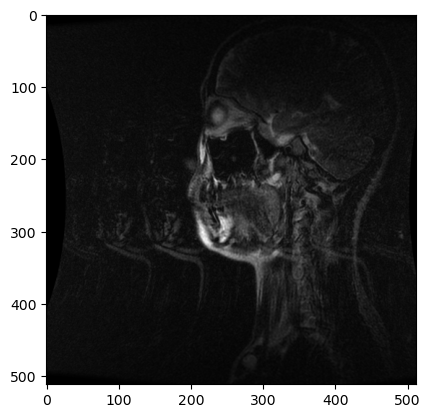

In [22]:
t2_path = 'sub001/t2w/dicom/IM-0001-0032.dcm'
ds = dicom.dcmread(t2_path)
print(ds.pixel_array.shape)
plt.imshow(ds.pixel_array, cmap='gray')
plt.show()

In [18]:
mat_file_path = 'sub001/3d/recon/sub001_3d_01_beet_r1_recon.mat'
mat_data = sio.loadmat(mat_file_path)
# mat_data.keys() # dict_keys(['__header__', '__version__', '__globals__', 'fov', 'param', 'pix', 'recon'])

reconstruction = mat_data['recon']
print(reconstruction.shape)

def plot_slice(slice_index):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    x, y, z = reconstruction.nonzero() # indices of non-zero elements
    mask = z == slice_index
    c = np.abs(reconstruction[x[mask], y[mask], z[mask]])
    ax.scatter(x[mask], y[mask], z[mask], c=c, cmap='gray')
    
    plt.show()

slice_slider = widgets.IntSlider(min=0, max=reconstruction.shape[2]-1, step=1, value=50, description='Slice:')
widgets.interact(plot_slice, slice_index=slice_slider)
display(slice_slider)

(160, 160, 80)


c:\ProgramData\miniconda3\envs\rp\Lib\site-packages\ipywidgets\widgets\interaction.py:43: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  from ipykernel.pylab.backend_inline import flush_figures


interactive(children=(IntSlider(value=50, description='Slice:', max=79), Output()), _dom_classes=('widget-inte…

IntSlider(value=50, description='Slice:', max=79)

In [19]:
raw2drt_path = 'sub001/2drt/raw/sub001_2drt_01_vcv1_r1_raw.h5'
rec2drt_path = 'sub001/2drt/recon/sub001_2drt_01_vcv1_r1_recon.h5'

raw_data = h5py.File(raw2drt_path, 'r')
raw_data.visititems(print)
print('--------------------------------------------------') 
rec_data = h5py.File(rec2drt_path, 'r')
rec_data.visititems(print)
print('--------------------------------------------------')

raw_data_dataset_data = raw_data['/dataset/data'][:] # shape (6436,)
raw_data_dataset_xml = raw_data['/dataset/xml'][:] # how to visualize this information?
recon_data = rec_data['/recon'][:]

raw_data_dataset_xml[0]

dataset <HDF5 group "/dataset" (2 members)>
dataset/data <HDF5 dataset "data": shape (6436,), type "|V372">
dataset/xml <HDF5 dataset "xml": shape (1,), type "|O">
--------------------------------------------------
iterations <HDF5 dataset "iterations": shape (1, 1), type "<f8">
lambda_s <HDF5 dataset "lambda_s": shape (1, 1), type "<f8">
lambda_t <HDF5 dataset "lambda_t": shape (1, 1), type "<f8">
recon <HDF5 dataset "recon": shape (3218, 84, 84), type "<f8">
--------------------------------------------------


b'<?xml version="1.0" encoding="utf-8"?><ismrmrdHeader xmlns="http://www.ismrm.org/ISMRMRD"><acquisitionSystemInformation><systemVendor>GE/Heartvista</systemVendor><systemModel>Signa Excite/RT Hawk</systemModel><systemFieldStrength_T>1.5</systemFieldStrength_T><receiverChannels>8</receiverChannels><institutionName>University of Southern California</institutionName><stationName>Los Angeles County Hospital</stationName></acquisitionSystemInformation><experimentalConditions><H1resonanceFrequency_Hz>128000000</H1resonanceFrequency_Hz></experimentalConditions><encoding><encodedSpace><matrixSize><x>84</x><y>84</y><z>1</z></matrixSize><fieldOfView_mm><x>20.0</x><y>20.0</y><z>6.0</z></fieldOfView_mm></encodedSpace><reconSpace><matrixSize><x>84</x><y>84</y><z>1</z></matrixSize><fieldOfView_mm><x>20.0</x><y>20.0</y><z>6.0</z></fieldOfView_mm></reconSpace><encodingLimits><kspace_encoding_step_0><minimum>0</minimum><maximum>0</maximum><center>0</center></kspace_encoding_step_0><kspace_encoding_ste

In [20]:
# Parse the XML data
xml_str = raw_data_dataset_xml[0].decode('utf-8')
root = ET.fromstring(xml_str)

# Function to strip namespace
def strip_namespace(tag):
    return tag.split('}', 1)[-1] if '}' in tag else tag

# Function to recursively extract XML elements into a dictionary / solution from Stackoverflow
def extract_xml_element(element, parent_key='', result=None):
    if result is None:
        result = {}
    for child in element:
        key = f"{parent_key}/{strip_namespace(child.tag)}" if parent_key else strip_namespace(child.tag)
        if len(child):
            extract_xml_element(child, key, result)
        else:
            result[key] = child.text
    return result

# Here I extract XML data into a dictionary
xml_data = extract_xml_element(root)

# Better visualization I think
df = pd.DataFrame(list(xml_data.items()), columns=['Element', 'Value'])
df.head(51)


,Element,Value
0,acquisitionSystemInformation/systemVendor,GE/Heartvista
1,acquisitionSystemInformation/systemModel,Signa Excite/RT Hawk
2,acquisitionSystemInformation/systemFieldStreng...,1.5
3,acquisitionSystemInformation/receiverChannels,8
4,acquisitionSystemInformation/institutionName,University of Southern California
5,acquisitionSystemInformation/stationName,Los Angeles County Hospital
6,experimentalConditions/H1resonanceFrequency_Hz,128000000
7,encoding/encodedSpace/matrixSize/x,84
8,encoding/encodedSpace/matrixSize/y,84
9,encoding/encodedSpace/matrixSize/z,1


b'<?xml version="1.0" encoding="utf-8"?><ismrmrdHeader xmlns="http://www.ismrm.org/ISMRMRD"><acquisitionSystemInformation><systemVendor>GE/Heartvista</systemVendor><systemModel>Signa Excite/RT Hawk</systemModel><systemFieldStrength_T>1.5</systemFieldStrength_T><receiverChannels>8</receiverChannels><institutionName>University of Southern California</institutionName><stationName>Los Angeles County Hospital</stationName></acquisitionSystemInformation><experimentalConditions><H1resonanceFrequency_Hz>128000000</H1resonanceFrequency_Hz></experimentalConditions><encoding><encodedSpace><matrixSize><x>84</x><y>84</y><z>1</z></matrixSize><fieldOfView_mm><x>20.0</x><y>20.0</y><z>6.0</z></fieldOfView_mm></encodedSpace><reconSpace><matrixSize><x>84</x><y>84</y><z>1</z></matrixSize><fieldOfView_mm><x>20.0</x><y>20.0</y><z>6.0</z></fieldOfView_mm></reconSpace><encodingLimits><kspace_encoding_step_0><minimum>0</minimum><maximum>0</maximum><center>0</center></kspace_encoding_step_0><kspace_encoding_ste

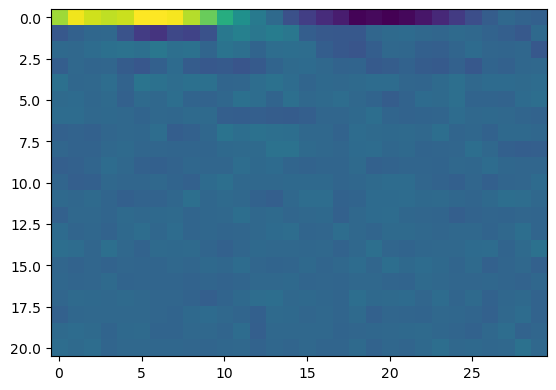

In [15]:
# Is it easier with ismrmrd? // no much difference
raw2drt_path = 'sub001/2drt/raw/sub001_2drt_01_vcv1_r1_raw.h5'
rec2drt_path = 'sub001/2drt/recon/sub001_2drt_01_vcv1_r1_recon.h5'

dset = ismrmrd.Dataset(raw2drt_path, 'dataset') # read dataset

print(dset.read_xml_header())

header = ismrmrd.xsd.CreateFromDocument(dset.read_xml_header()) # to parse img header

print('header has:',list(vars(header).keys()))
print('----')
print('header.encoding[0] has:',list(vars(header.encoding[0]).keys()))
print('----')

nX = header.encoding[0].encodedSpace.matrixSize.x
nY = header.encoding[0].encodedSpace.matrixSize.y
nZ = header.encoding[0].encodedSpace.matrixSize.z
nCoils = header.acquisitionSystemInformation.receiverChannels
print('nX: ', nX,'nY: ', nY,'nZ: ', nZ, 'nCoils: ', nCoils)

raw = np.zeros((nCoils, nX, nY), dtype=np.complex64)
print('Raw data shape: ', raw.shape)

a = dset.read_acquisition(0).data.reshape(nCoils, 21, 30) # not complete
print('a shape:', a.shape)

plt.imshow(a[0].real)

# for tr in range(nY):
#     raw[:,:,tr] = dset.read_acquisition(tr).data

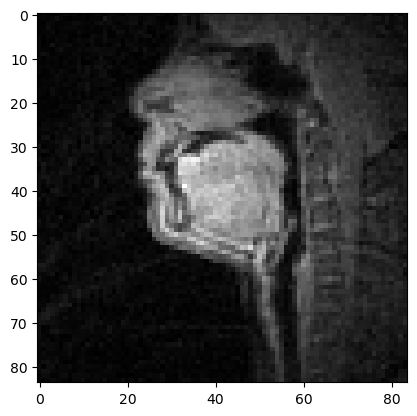

In [21]:
plt.imshow(recon_data[100, :, :].T, cmap='gray') # (3218, 84, 84)
plt.show()

In [4]:
video_path = r'..\data\sub001\2drt\video\sub001_2drt_01_vcv1_r1_video.mp4'

cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

frames = []
ret = True
while ret:
    ret, frame = cap.read()
    if ret:
        frames.append(frame)

cap.release()
frames = np.stack(frames, axis=0) # dimensions (T, H, W, C)
frames.shape

(3216, 84, 84, 3)

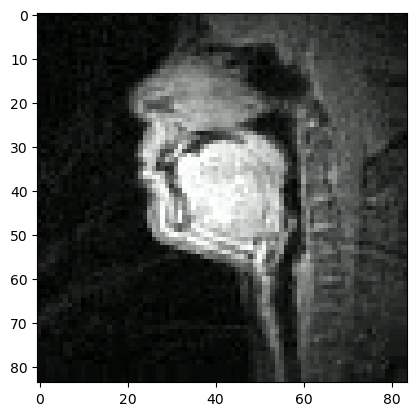

In [7]:
plt.imshow(frames[100, :, :, :])